### Links to Reference

In [2]:
# https://github.com/rodrigobressan/keras-multi-output-model-utk-face/blob/master/notebook.ipynb
# https://keras.io/guides/functional_api/
# https://stackoverflow.com/questions/66852823/how-to-implement-multilabel-classification-on-utkface-dataset-using-tensorflow-a
# https://www.tensorflow.org/guide/keras/train_and_evaluate
# https://stackoverflow.com/questions/61069068/keras-valueerror-dimensions-must-be-equal-but-are-6-and-9-for-node-equal
# figure out wtf is going on here

# https://www.analyticsvidhya.com/blog/2021/07/age-and-gender-detection-using-deep-learning/ 

### Imports

In [16]:
import os
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import cv2

### Image Labels
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

**age** is an integer from 0 to 116, indicating the age

**gender** is either 0 (male) or 1 (female)

**race** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

**date&time** is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [4]:
dataset_dict = {
    'race_id': {
        0: 'White', 
        1: 'Black', 
        2: 'Asian', 
        3: 'Indian', 
        4: 'Others'
    },
    'gender_id': {
        0: 'Male',
        1: 'Female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

dataset_dict

{'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'},
 'gender_id': {0: 'Male', 1: 'Female'},
 'gender_alias': {'Male': 0, 'Female': 1},
 'race_alias': {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}}

### Loading Data into Text and CSV Files

In [5]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [6]:
def parse_dataset_raw(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_raw_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), int(gender), int(race)
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_raw_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [7]:
dataset_path = "UTKFace"
df = parse_dataset(dataset_path)
df

,Age,Gender,Race,File
0,9.0,Female,Asian,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,Male,Black,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,Female,White,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,Female,White,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,Female,Asian,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,Male,White,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,Male,Indian,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,Male,Black,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,Male,Black,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [8]:
df_raw = parse_dataset_raw(dataset_path)
df_raw

,Age,Gender,Race,File
0,9.0,1.0,2.0,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,0.0,1.0,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,1.0,0.0,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,1.0,0.0,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,1.0,2.0,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,0.0,0.0,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,0.0,3.0,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,0.0,1.0,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,0.0,1.0,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [9]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img = fig.to_image(format="png")
    display(Image(img))

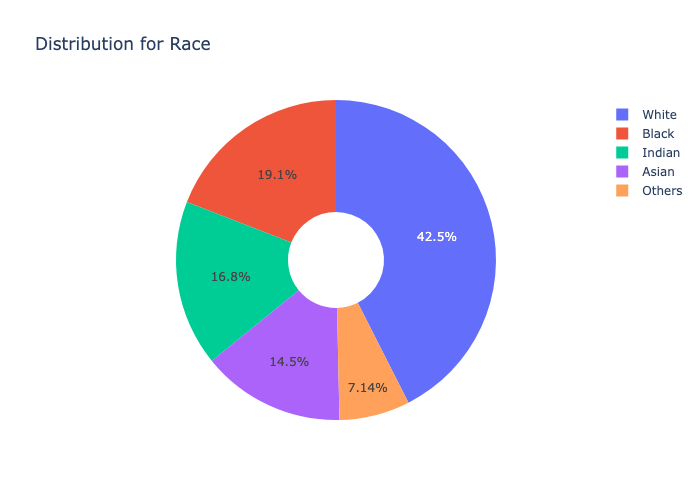

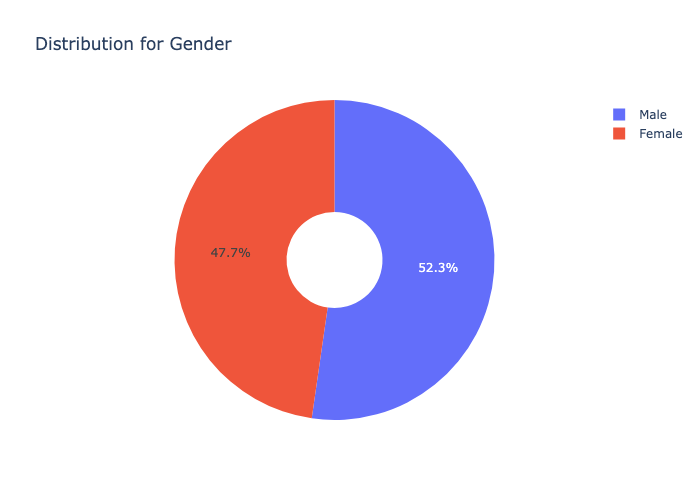

In [10]:
plot_distribution(df["Race"])
plot_distribution(df["Gender"])

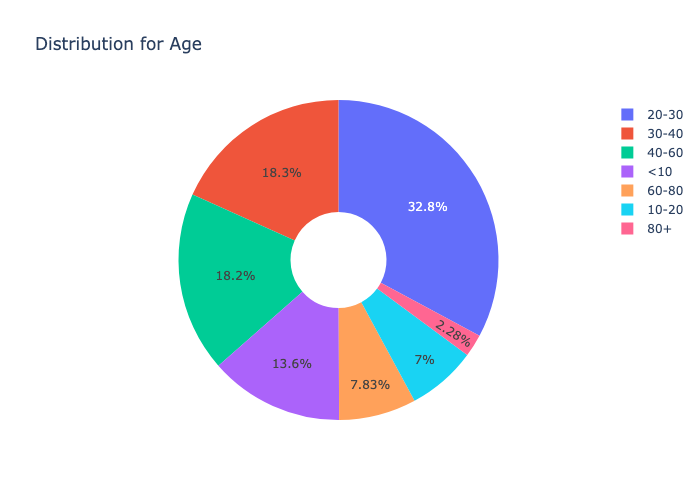

In [11]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['Age'], bins, labels=names)
plot_distribution(age_binned)
